In [7]:
!pip install segyio


In [8]:
import numpy as np
import os
import segyio

SEG_C3_URL = "http://s3.amazonaws.com/open.source.geoscience/open_data/seg_eage_salt/SEG_45Shot_shots1-9.sgy"
LOCAL_FILE = "seismic.sgy"
PATCH_SIZE = 224

# -------------------------
# DOWNLOAD SEG-Y
# -------------------------
if not os.path.exists(LOCAL_FILE):
    import requests
    print("Downloading SEG-Y file...")
    r = requests.get(SEG_C3_URL, stream=True)
    with open(LOCAL_FILE, "wb") as f:
        for chunk in r.iter_content(8192):
            f.write(chunk)
    print("Download complete.")
else:
    print("SEG-Y already exists.")

# -------------------------
# LOAD SEG-Y
# -------------------------
print("Reading SEG-Y...")
with segyio.open(LOCAL_FILE, "r", ignore_geometry=True) as f:
    traces = np.array([f.trace[i] for i in range(f.tracecount)], dtype=np.float32)

print("Raw traces loaded:", traces.shape)

# -------------------------
# FORCE 2D IMAGE (SAFE)
# -------------------------
min_len = min(len(t) for t in traces)
traces = np.stack([t[:min_len] for t in traces])

print("Uniform seismic image shape:", traces.shape)

# -------------------------
# NORMALIZE
# -------------------------
traces = (traces - traces.min()) / (traces.max() - traces.min() + 1e-8)

# -------------------------
# CREATE PATCHES
# -------------------------
patches = []
H, W = traces.shape

for i in range(0, H - PATCH_SIZE, PATCH_SIZE):
    for j in range(0, W - PATCH_SIZE, PATCH_SIZE):
        patches.append(traces[i:i+PATCH_SIZE, j:j+PATCH_SIZE])

patches = np.array(patches, dtype=np.float32)
np.save("seismic_patches.npy", patches)

print("✅ Patches created:", patches.shape)


SEG-Y already exists.
Reading SEG-Y...
Raw traces loaded: (363609, 625)
Uniform seismic image shape: (363609, 625)
✅ Patches created: (3246, 224, 224)


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim=256):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.norm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.norm2 = nn.BatchNorm2d(out_channels)
        self.time_proj = nn.Linear(time_emb_dim, out_channels)

    def forward(self, x, t):
        h = F.silu(self.norm1(self.conv1(x)))
        # dummy time embedding if t is None
        if t is None:
            t = torch.zeros(x.shape[0], 256, device=x.device)
        h = h + self.time_proj(F.silu(t))[:, :, None, None]
        h = F.silu(self.norm2(self.conv2(h)))
        return h

class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim=256):
        super().__init__()
        self.res = ResidualBlock(in_channels, out_channels, time_emb_dim)

    def forward(self, x, t):
        return self.res(x, t)

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Down blocks
        self.conv1 = nn.Conv2d(1, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.down1 = ResidualBlock(64, 128)
        self.down2 = ResidualBlock(128, 256)

        # Bottleneck
        self.bottleneck = ResidualBlock(256, 256)

        # Up blocks
        self.up1 = UpBlock(in_channels=256+256, out_channels=128)  # adjust channels
        self.up2 = UpBlock(in_channels=128+128, out_channels=64)

        # Final conv
        self.final = nn.Conv2d(64, 1, 1)

    def forward(self, x, t=None):
        x1 = F.silu(self.conv1(x))
        x2 = F.silu(self.conv2(x1))
        d1 = self.down1(x1, t)
        d2 = self.down2(x2, t)
        b = self.bottleneck(d2, t)

        x = self.up1(torch.cat([b, d2], 1), t)
        x = F.interpolate(x, size=x1.shape[2:])
        x = self.up2(torch.cat([x, d1], 1), t)

        return self.final(x)

# Test the model
model = UNet().to(device)
dummy_input = torch.randn(2,1,64,64).to(device)  # batch=2, 1 channel, 64x64
output = model(dummy_input)
print("Output shape:", output.shape)


Output shape: torch.Size([2, 1, 64, 64])


Loading SEG-Y file: /kaggle/working/seismic.sgy...
Extracted 3246 non-overlapping patches.
First batch input shape: torch.Size([16, 1, 224, 224]), target shape: torch.Size([16, 1, 224, 224])


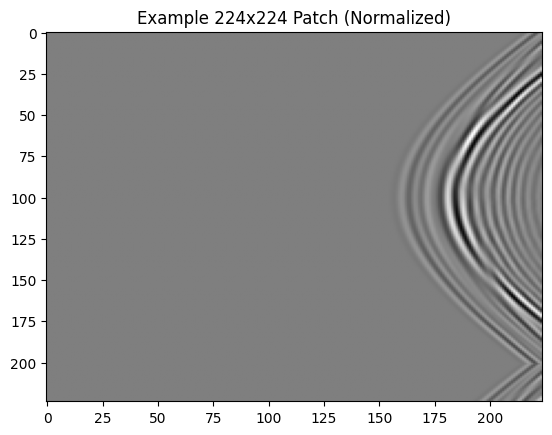

In [10]:
import segyio
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader

# --- Configuration ---
LOCAL_FILE_NAME = "/kaggle/working/seismic.sgy"
BATCH_SIZE = 16

# --- I. DATA LOADING AND CONVERSION ---

def segy_to_numpy(filename):
    """Loads a SEG-Y file and converts the seismic traces into a NumPy array."""
    if not os.path.exists(filename):
        print(f"File not found: {filename}. Cannot load data.")
        return None

    print(f"Loading SEG-Y file: {filename}...")
    try:
        with segyio.open(filename, 'r', ignore_geometry=True) as segyfile:
            num_traces = segyfile.tracecount
            num_samples = segyfile.samples.size
            trace_data = [segyfile.trace[i] for i in range(num_traces)]
            traces_array = np.array(trace_data)
            reshaped_data = traces_array.reshape(num_traces, num_samples)
            return np.ascontiguousarray(reshaped_data)
    except Exception as e:
        print(f"Error reading SEG-Y file: {e}")
        return None

# --- II. DATA PATCHING ---

def create_image_patches(seismic_data_np, patch_size=PATCH_SIZE):
    data_min = seismic_data_np.min()
    data_max = seismic_data_np.max()
    normalized_data = (seismic_data_np - data_min) / (data_max - data_min + 1e-9)

    traces, samples = normalized_data.shape
    patches = []
    for i in range(0, traces - patch_size + 1, patch_size):
        for j in range(0, samples - patch_size + 1, patch_size):
            patch = normalized_data[i:i + patch_size, j:j + patch_size]
            patches.append(patch)
    print(f"Extracted {len(patches)} non-overlapping patches.")
    return patches

# --- III. PYTORCH DATASET/DATALOADER ---

class SeismicDataset(Dataset):
    def __init__(self, patches):
        self.patches = patches
    def __len__(self):
        return len(self.patches)
    def __getitem__(self, idx):
        patch_tensor = torch.from_numpy(self.patches[idx]).float().unsqueeze(0)
        return patch_tensor, patch_tensor

def get_unet_dataloader(patches, batch_size=BATCH_SIZE):
    dataset = SeismicDataset(patches)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

# --- IV. EXECUTION ---

seismic_data_np = segy_to_numpy(LOCAL_FILE_NAME)

if seismic_data_np is not None:
    image_patches = create_image_patches(seismic_data_np, patch_size=PATCH_SIZE)
    unet_dataloader = get_unet_dataloader(image_patches)
    
    # Example: Check first batch
    first_batch = next(iter(unet_dataloader))
    X_batch, Y_batch = first_batch
    print(f"First batch input shape: {X_batch.shape}, target shape: {Y_batch.shape}")

    # Display first patch
    plt.imshow(image_patches[0], aspect='auto', cmap='gray')
    plt.title("Example 224x224 Patch (Normalized)")
    plt.show()



--- Visualizing Rotated Patch ---
Rotating 90 degrees clockwise to match standard seismic orientation (Traces on top, Time/Depth going down).
Original shape: (224, 224)
Rotated shape:  (224, 224)


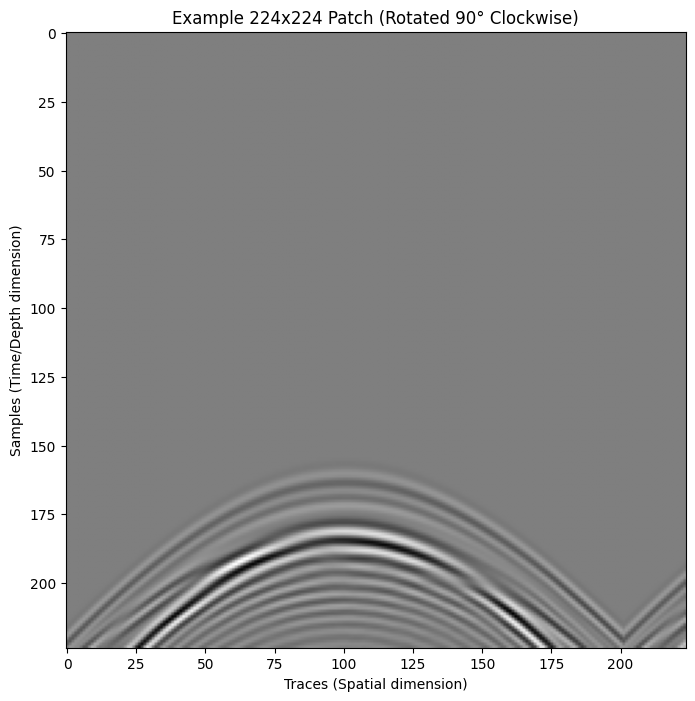

In [11]:
# --- VI. CORRECTED VISUALIZATION (Follow-up Cell) ---

# Ensure we have patches to visualize
if 'image_patches' in locals() and len(image_patches) > 0:
    print("\n--- Visualizing Rotated Patch ---")
    print("Rotating 90 degrees clockwise to match standard seismic orientation (Traces on top, Time/Depth going down).")

    # 1. Get the same first patch again
    original_patch = image_patches[0]

    # 2. Apply Transpose (.T) to swap axes.
    # Original shape was (Traces, Samples). New shape is (Samples, Traces).
    rotated_patch = original_patch.T

    print(f"Original shape: {original_patch.shape}")
    print(f"Rotated shape:  {rotated_patch.shape}")

    # 3. Plot the rotated patch
    plt.figure(figsize=(8, 8)) # Optional: make it a bit bigger
    plt.imshow(rotated_patch, aspect='auto', cmap='gray')
    plt.title("Example 224x224 Patch (Rotated 90° Clockwise)")

    # IMPORTANT: Update labels to reflect the rotation
    plt.xlabel("Traces (Spatial dimension)")
    plt.ylabel("Samples (Time/Depth dimension)")

    # Often in seismic, we want depth/time to increase downwards,
    # though imshow usually does this by default for matrices.
    # If it looks upside down, uncomment the next line:
    # plt.gca().invert_yaxis()

    plt.show()
else:
    print("No patches found in memory. Please run the previous code block successfully first.")

In [12]:
import segyio
import numpy as np
import os

# --- Configuration ---
LOCAL_FILE_NAME = "/kaggle/working/seismic.sgy"
PATCH_SIZE = 224

# --- I. DATA LOADING ---

def segy_to_numpy(filename):
    print(f"Loading {filename}...")
    try:
        with segyio.open(filename, 'r', ignore_geometry=True) as f:
            return np.stack([f.trace[i] for i in range(f.tracecount)])
    except Exception as e:
        print(f"Error loading SEG-Y: {e}")
        return None

# --- II. PATCHING (RAW, NO NORMALIZATION) ---

def create_raw_patches(seismic_data_np, patch_size=PATCH_SIZE):
    print(f"\n--- Extracting Raw Patches ({patch_size}x{patch_size}) ---")
    traces, samples = seismic_data_np.shape
    patches = []

    for i in range(0, traces - patch_size + 1, patch_size):
        for j in range(0, samples - patch_size + 1, patch_size):
            patch = seismic_data_np[i:i+patch_size, j:j+patch_size]
            patches.append(patch)

    print(f"Extracted {len(patches)} patches.")
    return patches

# --- Execution ---
raw_data = segy_to_numpy(LOCAL_FILE_NAME)

if raw_data is not None:
    patches = create_raw_patches(raw_data)
    print(f"Ready to proceed with {len(patches)} patches.")


Loading /kaggle/working/seismic.sgy...

--- Extracting Raw Patches (224x224) ---
Extracted 3246 patches.
Ready to proceed with 3246 patches.


Original Data Shape: (363609, 625)
Transposed Data Shape: (625, 363609) (Time x Traces)
Created 3246 patches from oriented data.


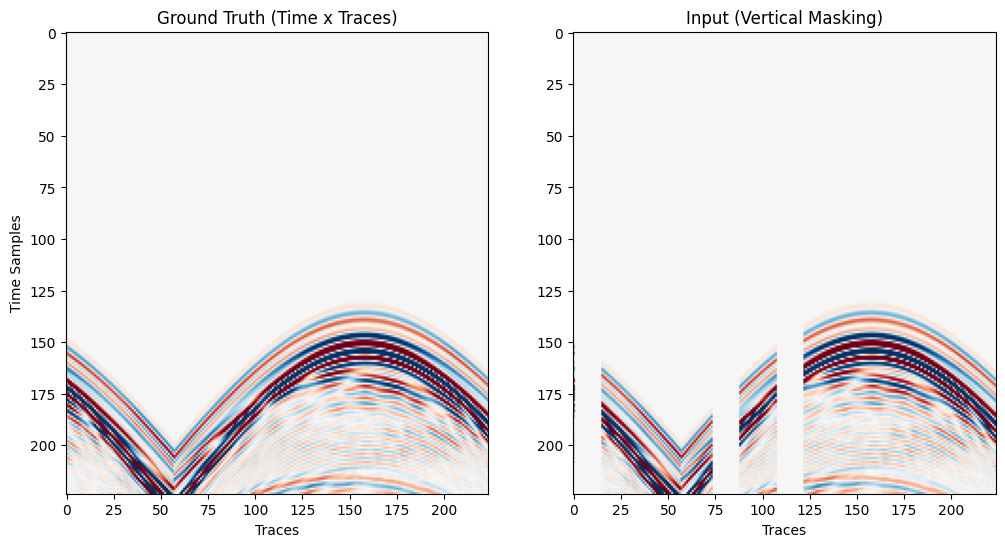

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader

# --- 1. RE-LOAD & FIX ORIENTATION ---
# We assume 'seismic_data_np' is already loaded from previous cells.
# If not, re-run the segy_to_numpy step.

def fix_seismic_orientation(data):
    """
    Ensures data is (Time, Traces).
    Current Shape is likely (Traces, Samples).
    We want Transpose -> (Samples, Traces).
    """
    print(f"Original Data Shape: {data.shape}")
    # Check if we need to transpose. Usually samples > traces in a full section,
    # but for this specific file, let's just force the transpose to match the standard.
    data_t = data.T
    print(f"Transposed Data Shape: {data_t.shape} (Time x Traces)")
    return data_t

# --- 2. PATCHING (Now on Time x Traces) ---
def create_oriented_patches(data, patch_size=224):
    h, w = data.shape # h=Time, w=Traces
    patches = []
    # Slide over Time (H) and Traces (W)
    for i in range(0, h - patch_size + 1, patch_size):
        for j in range(0, w - patch_size + 1, patch_size):
            patch = data[i:i+patch_size, j:j+patch_size]
            patches.append(patch)
    print(f"Created {len(patches)} patches from oriented data.")
    return patches

# --- 3. DATASET WITH CORRECT MASKING ---
class SeismicCorrectedDataset(Dataset):
    def __init__(self, patches):
        self.patches = patches

    def __len__(self):
        return len(self.patches)

    def __getitem__(self, idx):
        patch = self.patches[idx]

        # Normalization (Standard Deviation)
        std = np.std(patch)
        if std > 0:
            patch = patch / (3 * std)
        patch = np.clip(patch, -1, 1)

        # To Tensor: (1, Height=Time, Width=Traces)
        patch_tensor = torch.from_numpy(patch).float().unsqueeze(0)

        # Masking: Now applied to Width (Traces)
        c, h, w = patch_tensor.shape
        mask = torch.ones((c, h, w))

        # Mask 20% of the traces (vertical strips)
        mask_ratio = 0.2
        gap_width = int(w * mask_ratio // 3) # 3 gaps

        for _ in range(3):
            start = torch.randint(0, w - gap_width, (1,)).item()
            mask[:, :, start:start + gap_width] = 0.0

        masked_img = patch_tensor * mask
        return masked_img, patch_tensor, mask

# --- 4. EXECUTION & VISUALIZATION ---
if 'raw_data' in locals():
    oriented_data = fix_seismic_orientation(raw_data)

    # 2. Patch
    fixed_patches = create_oriented_patches(oriented_data)

    # 3. Dataset
    ds = SeismicCorrectedDataset(fixed_patches)

    # 4. Visualize
    masked, gt, mask = ds[15] # Pick index 15 to ensure we see waves

    # No transpose needed for plotting now! Data is already (Time, Traces)
    vis_masked = masked.squeeze()
    vis_gt = gt.squeeze()

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Ground Truth
    ax[0].imshow(vis_gt, cmap='RdBu', aspect='auto', vmin=-1, vmax=1)
    ax[0].set_title("Ground Truth (Time x Traces)")
    ax[0].set_xlabel("Traces")
    ax[0].set_ylabel("Time Samples")

    # Masked Input
    ax[1].imshow(vis_masked, cmap='RdBu', aspect='auto', vmin=-1, vmax=1)
    ax[1].set_title("Input (Vertical Masking)")
    ax[1].set_xlabel("Traces")

    plt.show()
else:
    print("Please ensure 'seismic_data_np' is loaded first.")

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset
import math
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

# --- 1. SEISMIC CONFIGURATION ---
TIMESTEPS = 1000       # Standard diffusion steps
IMAGE_SIZE = 224       # Matches your patch size
CHANNELS = 1           # CRITICAL: Seismic is Grayscale (1 Channel)
BATCH_SIZE = 8         # Reduced to 8 to fit 224x224 on standard GPUs
LEARNING_RATE = 1e-4
EPOCHS = 100           # Total epochs
LOG_INTERVAL = 100     
SAMPLE_INTERVAL = 5
FAST_SAMPLING_STEPS = 50

# --- CHANGE 1: INPUT CHECKPOINT (Using your exact file path) ---
INPUT_CHECKPOINT = '/kaggle/input/seismic-ddpm-weights/pytorch/epoch-100/1/epoch 100.pt'

# --- CHANGE 2: WORKING DIRECTORY (Required for any new saves) ---
CHECKPOINT_DIR = '/kaggle/working/seismic_checkpoints'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)


# --- Helper to save the full training state ---
def save_checkpoint(model, optimizer, epoch, loss, filename):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }
    torch.save(checkpoint, filename)
    print(f"  --> Checkpoint saved: {filename}")

# --- CHANGE 3: REWIRED LOADING FUNCTION (Handles your exact file) ---
def load_checkpoint(model, optimizer, filename, device):
    if os.path.exists(filename):
        print(f"✅ Loading model from {filename}...")
        checkpoint = torch.load(filename, map_location=device)
        
        # Check if file is a full checkpoint or just weights
        if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
            model.load_state_dict(checkpoint['model_state_dict'])
            if optimizer is not None and 'optimizer_state_dict' in checkpoint:
                optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            start_epoch = checkpoint['epoch'] + 1
        else:
            # Handle the case where the file is just the weights (state_dict)
            model.load_state_dict(checkpoint)
            start_epoch = 101 # You've already done 100 epochs
            
        print(f"🚀 Success! Model restored. Resuming from epoch {start_epoch}.")
        return start_epoch
    else:
        print(f"❌ No checkpoint found at {filename}. Starting fresh.")
        return 1

# --- Dataset and Masking Definitions ---

def apply_vertical_mask(patch_tensor, mask_ratio=0.2, num_gaps=3):
    c, h, w = patch_tensor.shape
    mask = torch.ones((c, h, w))
    gap_width = int((w * mask_ratio) / num_gaps)
    for _ in range(num_gaps):
        start = torch.randint(0, w - gap_width, (1,)).item()
        mask[:, :, start:start + gap_width] = 0.0
    masked_patch = patch_tensor * mask
    return masked_patch, mask

class SeismicDDPMDataset(Dataset):
    def __init__(self, patches):
        self.patches = patches
    def __len__(self):
        return len(self.patches)
    def __getitem__(self, idx):
        patch = self.patches[idx]
        std_val = np.std(patch)
        if std_val > 0:
            patch = patch / (3 * std_val)
        patch = np.clip(patch, -1.0, 1.0)
        patch_tensor = torch.from_numpy(patch).float().unsqueeze(0)
        masked_img, mask = apply_vertical_mask(patch_tensor)
        return masked_img, patch_tensor, mask

# --- 2. MODEL ARCHITECTURE (U-Net) ---

def get_time_embedding(timesteps, embedding_dim=128):
    half_dim = embedding_dim // 2
    emb = math.log(10000) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, device=timesteps.device) * -emb)
    timesteps = timesteps.float().unsqueeze(1)
    emb = timesteps * emb.unsqueeze(0)
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
    if embedding_dim % 2 == 1:
        emb = F.pad(emb, [0, 1])
    return emb

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_embedding_dim=128):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.gn1 = nn.GroupNorm(8, out_channels)
        self.time_proj = nn.Linear(time_embedding_dim, out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.gn2 = nn.GroupNorm(8, out_channels)
        self.residual_conv = nn.Conv2d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()
    def forward(self, x, t_emb):
        h = self.conv1(x)
        h = self.gn1(h)
        h = F.silu(h)
        time_term = self.time_proj(F.silu(t_emb))
        h = h + time_term.view(-1, time_term.size(-1), 1, 1)
        h = self.conv2(h)
        h = self.gn2(h)
        h = F.silu(h)
        return h + self.residual_conv(x)

class Unet(nn.Module):
    def __init__(self, in_channels=CHANNELS, out_channels=CHANNELS, dim=64, dim_mults=(1, 2, 4, 8)):
        super().__init__()
        self.time_embedding_dim = dim * 4
        self.init_conv = nn.Conv2d(in_channels, dim, 7, padding=3)
        dims = [dim, *[dim * m for m in dim_mults]]
        in_out = list(zip(dims[:-1], dims[1:]))
        self.downs = nn.ModuleList([])
        for i, (dim_in, dim_out) in enumerate(in_out):
            self.downs.append(nn.ModuleList([
                ResidualBlock(dim_in, dim_out, self.time_embedding_dim),
                ResidualBlock(dim_out, dim_out, self.time_embedding_dim),
                nn.MaxPool2d(2) if i != len(in_out) - 1 else nn.Identity()
            ]))
        mid_dim = dims[-1]
        self.mid_block1 = ResidualBlock(mid_dim, mid_dim, self.time_embedding_dim)
        self.mid_block2 = ResidualBlock(mid_dim, mid_dim, self.time_embedding_dim)
        self.ups = nn.ModuleList([])
        for i, (dim_in, dim_out) in enumerate(reversed(in_out)):
            self.ups.append(nn.ModuleList([
                ResidualBlock(dim_out + dim_out, dim_in, self.time_embedding_dim),
                ResidualBlock(dim_in, dim_in, self.time_embedding_dim),
                nn.Upsample(scale_factor=2, mode='nearest') if i != len(in_out) - 1 else nn.Identity()
            ]))
        self.final_conv = nn.Conv2d(dim, out_channels, 1)
    def forward(self, x, timesteps):
        t_emb = get_time_embedding(timesteps, self.time_embedding_dim)
        x = self.init_conv(x)
        h = []
        for res_block1, res_block2, downsample in self.downs:
            x = res_block1(x, t_emb)
            x = res_block2(x, t_emb)
            h.append(x)
            x = downsample(x)
        x = self.mid_block1(x, t_emb)
        x = self.mid_block2(x, t_emb)
        for res_block1, res_block2, upsample in self.ups:
            skip = h.pop()
            x = F.interpolate(x, size=skip.shape[2:])
            x = torch.cat((x, skip), dim=1)
            x = res_block1(x, t_emb)
            x = res_block2(x, t_emb)
            x = upsample(x)
        return self.final_conv(x)

# --- 3. DDPM SCHEDULE ---

class NoiseSchedule(object):
    def __init__(self, timesteps=TIMESTEPS, beta_start=0.0001, beta_end=0.02):
        self.timesteps = timesteps
        self.betas = torch.linspace(beta_start, beta_end, timesteps)
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)
    def _extract(self, a, t, x_shape):
        b, *_ = t.shape
        out = a.gather(-1, t) 
        return out.reshape(b, *((1,) * (len(x_shape) - 1)))
    def q_sample(self, x_start, t, noise=None):
        if noise is None: noise = torch.randn_like(x_start)
        t = t.to(x_start.device)
        sqrt_alpha_bar_t = self._extract(self.sqrt_alphas_cumprod.to(x_start.device), t, x_start.shape)
        sqrt_one_minus_alpha_bar_t = self._extract(self.sqrt_one_minus_alphas_cumprod.to(x_start.device), t, x_start.shape)
        return sqrt_alpha_bar_t * x_start + sqrt_one_minus_alpha_bar_t * noise, noise

# --- 4. TRAINING LOOP ---

def train_seismic_ddpm(patches_list):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Starting Training on {device}...")

    full_dataset = SeismicDDPMDataset(patches_list)
    train_size = int(0.9 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_ds, val_ds = random_split(full_dataset, [train_size, val_size])

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
    print(f"Training on {len(train_ds)} patches, Validation on {len(val_ds)} patches.")

    model = Unet(in_channels=CHANNELS, out_channels=CHANNELS).to(device)
    schedule = NoiseSchedule()
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    mse_loss = nn.MSELoss()

    # REWIRED CALL: Use the specific INPUT_CHECKPOINT variable
    start_epoch = load_checkpoint(model, optimizer, INPUT_CHECKPOINT, device)

    # The loop will now start from epoch 101 if the load was successful
    for epoch in range(start_epoch, EPOCHS + 1):
        model.train()
        epoch_loss = 0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}", leave=False)
        for step, (masked, clean_target, mask) in enumerate(pbar):
            clean_target = clean_target.to(device)
            t = torch.randint(0, TIMESTEPS, (clean_target.shape[0],), device=device).long()
            noise = torch.randn_like(clean_target)
            x_noisy, noise = schedule.q_sample(clean_target, t, noise)
            predicted_noise = model(x_noisy, t)
            loss = mse_loss(predicted_noise, noise)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(train_loader)
        print(f"Epoch {epoch} | Loss: {avg_loss:.5f}")

        # Save updates to the writable WORKING directory
        latest_path = os.path.join(CHECKPOINT_DIR, 'ddpm_seismic_latest.pt')
        save_checkpoint(model, optimizer, epoch, avg_loss, latest_path)

    print("Training Complete. Model is ready for Inpainting.")
    return model, schedule

# --- 5. EXECUTION ---
if __name__ == "__main__":
    if 'patches' in locals() and len(patches) > 0:
        trained_model, noise_schedule = train_seismic_ddpm(patches)
    else:
        print("Variable 'patches' not found. Did you run the Data Loading cell?")

Starting Training on cuda...
Training on 2921 patches, Validation on 325 patches.
✅ Loading model from /kaggle/input/seismic-ddpm-weights/pytorch/epoch-100/1/epoch 100.pt...
🚀 Success! Model restored. Resuming from epoch 101.
Training Complete. Model is ready for Inpainting.


In [40]:
# --- REUSABLE TESTING BLOCK ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Prepare the Dataset (Using the same patches as training)
# We recreate the loader here to ensure 'full_dataset' is found
full_dataset = SeismicDDPMDataset(patches) 
test_loader = DataLoader(full_dataset, batch_size=1, shuffle=True)
masked_input, clean_target, mask = next(iter(test_loader))

# 2. Move to GPU
masked_input = masked_input.to(device)
mask = mask.to(device)
clean_target = clean_target.to(device)

# 3. Run Interpolation
# We use 'trained_model' and 'noise_schedule' returned from your training function
reconstructed = interpolate_seismic(trained_model, noise_schedule, masked_input, mask, device)

# 4. Professional Seismic Visualization
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.title("Ground Truth (Original)", fontsize=12)
plt.imshow(clean_target[0,0].cpu(), cmap='RdBu', aspect='auto')
plt.colorbar(label='Amplitude')

plt.subplot(1, 3, 2)
plt.title("Input (Missing Traces)", fontsize=12)
plt.imshow(masked_input[0,0].cpu(), cmap='RdBu', aspect='auto')
plt.colorbar(label='Amplitude')

plt.subplot(1, 3, 3)
plt.title("DDPM Output (Interpolated)", fontsize=12)
plt.imshow(reconstructed[0,0].cpu(), cmap='RdBu', aspect='auto')
plt.colorbar(label='Amplitude')

plt.tight_layout()
plt.show()

Inpainting: 100%|██████████| 1000/1000 [00:20<00:00, 49.02it/s]


In [41]:
import matplotlib
matplotlib.use('Agg') # Force non-interactive backend to prevent canvas clearing
import matplotlib.pyplot as plt

# 1. Initialize the figure
fig = plt.figure(figsize=(18, 6))

# 2. Plot your results (using the variables from your successful 100-epoch run)
plt.subplot(1, 3, 1)
plt.title("Ground Truth (Original)")
plt.imshow(clean_target[0,0].cpu(), cmap='RdBu', aspect='auto')

plt.subplot(1, 3, 2)
plt.title("Input (Missing Traces)")
plt.imshow(masked_input[0,0].cpu(), cmap='RdBu', aspect='auto')

plt.subplot(1, 3, 3)
plt.title("DDPM Output (Interpolated)")
plt.imshow(reconstructed[0,0].cpu(), cmap='RdBu', aspect='auto')

plt.tight_layout()

# 3. Save directly using the figure object (this is more robust than plt.savefig)
fig.savefig('/kaggle/working/seismic_final_fixed.png', dpi=300, bbox_inches='tight')
print("✅ SUCCESS: Check your Output pane for 'seismic_final_fixed.png'")

✅ SUCCESS: Check your Output pane for 'seismic_final_fixed.png'


In [ ]:
import os
from kaggle_secrets import UserSecretsClient

# 1. Access your secured token
user_secrets = UserSecretsClient()
token = user_secrets.get_secret("github_token")

# 2. Project Details
USERNAME = "Harshitha-katturajan" 
REPO_NAME = "Seismic-Data-Interpolation-Using-DDPM"
EMAIL = "katturajanharshitha@gmail.com" 

# 3. Setup the .gitignore (To keep the repo clean)
gitignore_content = """
__pycache__/
*.csv
*.npy
*.npz
*.segy
.virtual_documents/
"""
with open("/kaggle/working/.gitignore", "w") as f:
    f.write(gitignore_content)

# 4. Git Commands
%cd /kaggle/working
!git init
!git config --global user.email "{EMAIL}"
!git config --global user.name "{USERNAME}"
!git add .
!git commit -m "Initial commit: Seismic Data Interpolation project"

# 5. Push to GitHub
remote_url = f"https://{token}@github.com/{USERNAME}/{REPO_NAME}.git"
!git remote add origin {remote_url}
!git branch -M main
!git push -u origin main